חלק א': הכנת הנתונים והבנת הנתונים של טבלת המכירות

ייבוא וארגון הדאטה בפייתון

1.import the csv files 

In [7]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to your CSV files
file1 = './Products.csv'
file2 = './Transactions.csv'

2.read the csv

In [8]:
# Read the CSV files
Products = pd.read_csv(file1)
Transactions = pd.read_csv(file2)

הבנת מבנה הנתונים:


1.2.1 - תשובה על סעיף 1 

2.2.1 - תשובה על סעיף 2 

3.2.1 - תשובה על סעיף 3 

איחוד הטבלאות:


1.Merge tables using the Product field


In [9]:

# Merge tables using the Product field
df_transactions = pd.DataFrame(Transactions)
df_Products = pd.DataFrame(Products)
df_transactions.columns = df_transactions.columns.str.strip()
df_Products.columns = df_Products.columns.str.strip()
enriched_data = pd.merge(df_transactions, df_Products, on="Product", how="left")
df = pd.DataFrame(enriched_data)
output_filename = "enriched_data.csv"
df.to_csv(output_filename, index=False)

2.Split the 'Segement_Country' column into 'Segment' and 'Country' and drop the old column

In [10]:
# Split the 'Segement_Country' column into 'Segment' and 'Country'
df[['Segment', 'Country']] = df['Segement_Country'].str.split('-', expand=True)
# Drop the original 'Segement_Country' column if it's no longer needed
df = df.drop(columns=['Segement_Country'])
output_filename = "drop_Segement_Country.csv"
df.to_csv(output_filename, index=False)

בדיקת תקינות:


1,2.checking if the merge was ok

In [11]:
def validate_merge(df_transactions, df_products, merged_df, key_column="Product"):
    # Check if all products in df_transactions exist in df_products
    missing_products = df_transactions[~df_transactions[key_column].isin(df_products[key_column])][key_column].unique()
    
    # Check for any rows where the merge resulted in missing values
    missing_values = merged_df.isnull().sum().sum()  # Count total missing values
    
    # Print or return results
    if len(missing_products) == 0 and missing_values == 0:
        print("Merge successful! No data was lost.")
        return True
    else:
        print(f"Warning: {len(missing_products)} products in transactions were not found in products.")
        if len(missing_products) > 0:
            print("Missing Products:", missing_products)
        print(f"Total missing values after merge: {missing_values}")
        return False

# Usage
is_merge_valid = validate_merge(df_transactions, df_Products, enriched_data)

Total missing values after merge: 53


In [12]:
#Check if no data missing after mergin
print(df.isnull().sum())  # Check for nulls in any column
print(f"Rows in Products DataFrame: {Products.shape[0]}")
print(f"Rows in Transactions DataFrame: {Transactions.shape[0]}")
print(f"Rows in Enriched Data: {df.shape[0]}")
print(df.columns)
print(df['Product'].value_counts())

Product                 0
Discount Band          53
Units Sold              0
Sale Price              0
Gross Sales             0
Discounts               0
Sales                   0
COGS                    0
Profit                  0
Date                    0
Month Number            0
ProductID               0
Category                0
Manufacturing Price     0
Segment                 0
Country                 0
dtype: int64
Rows in Products DataFrame: 6
Rows in Transactions DataFrame: 700
Rows in Enriched Data: 700
Index(['Product', 'Discount Band', 'Units Sold', 'Sale Price', 'Gross Sales',
       'Discounts', 'Sales', 'COGS', 'Profit', 'Date', 'Month Number',
       'ProductID', 'Category', 'Manufacturing Price', 'Segment', 'Country'],
      dtype='object')
Product
Paseo        202
Velo         109
VTT          109
Amarilla      94
Carretera     93
Montana       93
Name: count, dtype: int64


3.3.1- תשובה לשאלה 3 

טיפול בנתונים : 


נתונים כספיים


1.deal with the format of the  financial details

In [13]:

# Define a function to clean the financial fields
def clean_financial_field(value):
    if isinstance(value, (int, float)):  # If already a number, return it as is
        return value
    # Remove non-numeric characters (e.g., $, commas, extra dots)
    clean_value = (
        value.replace("$", "")
             .replace(",", "")
             .replace(".", "", value.count(".") - 1)  # Handle decimal points correctly
    )
    try:
        return float(clean_value)  # Convert to a float for analysis
    except ValueError:
        return None  # Return None for non-convertible values
    
# Identify the financial fields that need cleanup
financial_fields = ["Sale Price", "Gross Sales", "Discounts", "Sales", "COGS", "Profit","Manufacturing Price"]

# Apply the cleaning function to each field
for field in financial_fields:
    df[field] = df[field].apply(clean_financial_field)
    
output_filename = "financial_fields.csv"
df.to_csv(output_filename, index=False) 

2.1.2 - תשובה לשאלה 2 

עמודת _Segment_Country:


טיפול בנתוני התאריך


העמודה תאריך בטבלה זו מייצגת את העסקה או את תאריך המכירה שבו התרחשה מכירה מסוימת. הוא מתעד את היום, החודש והשנה המדויקים של המכירה.

2,3.Format Date Column and after it formated i create two more columns ,month_name,and year.
also i print the wrong/unusual dates

In [14]:

# Format Date Column
def validate_and_fix_date(row):
    try:
        # Parse the existing date
        date = pd.to_datetime(row['Date'], format='%m/%d/%Y', errors='coerce')
        
        # Check if the date's month matches the Month Number column
        if date and date.month != row['Month Number']:
            print(date.month , row['Month Number'])
            # Correct the date by aligning it with the Month Number column
            corrected_date = pd.Timestamp(year=date.year, month=row['Month Number'], day=1)
        else:
            corrected_date = date
    except:
        # Handle invalid or unusual dates
        print(row['Date'])
        

    return corrected_date

# Identify unusual or missing dates
df['Date'] = df.apply(validate_and_fix_date, axis=1)

# Format the Corrected Date into a single consistent format
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')
df['Date'] = pd.to_datetime(df['Date'])
df['Year']=df['Date'].dt.year

df["Month Name"] = df["Month Number"].apply(lambda x: calendar.month_name[x])
# df["Year"] = df["Date"].dt.year

output_filename = "add_year_month.csv"
df.to_csv(output_filename, index=False) 

4.2.2 - תשובה לשלאלה 4 

יצירת עמודות מחושבות

1.add to df two columns : Discount Impact,Profit Margin

In [15]:
#create new Discount Impact column
df['Discount Impact'] = df['Discounts'] / df['Sales']
df['Profit Margin'] = (df['Profit'] / df['Sales']) * 100
output_filename = "create_two_new_columns.csv"
df.to_csv(output_filename, index=False)

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_92479/3809226553.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product', y='Discount Impact', data=df, palette="Blues_d")


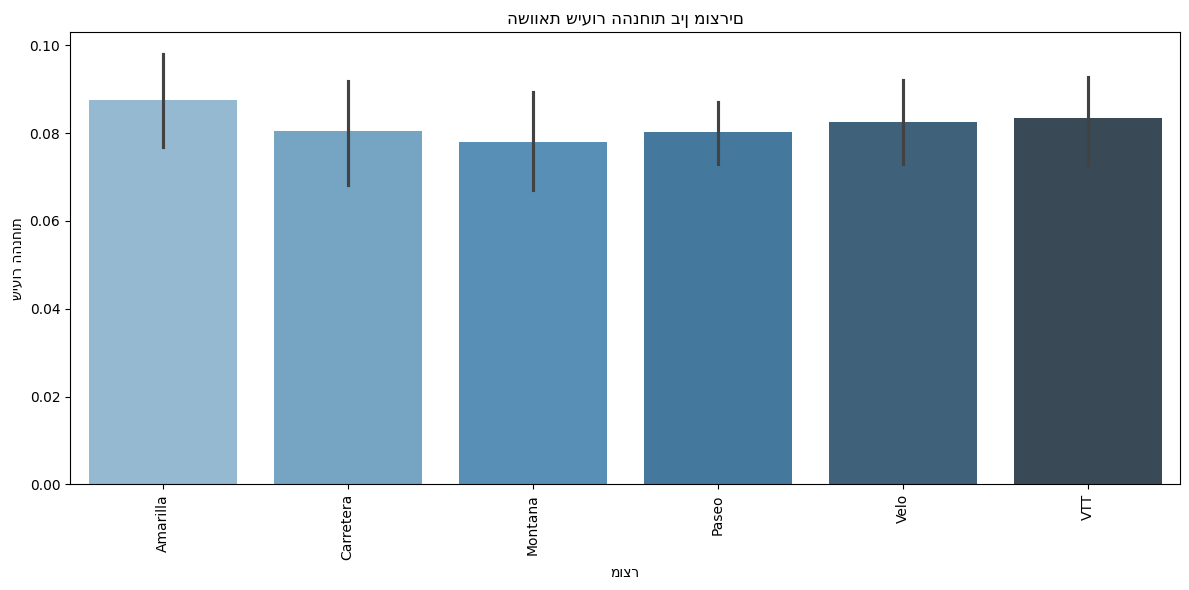

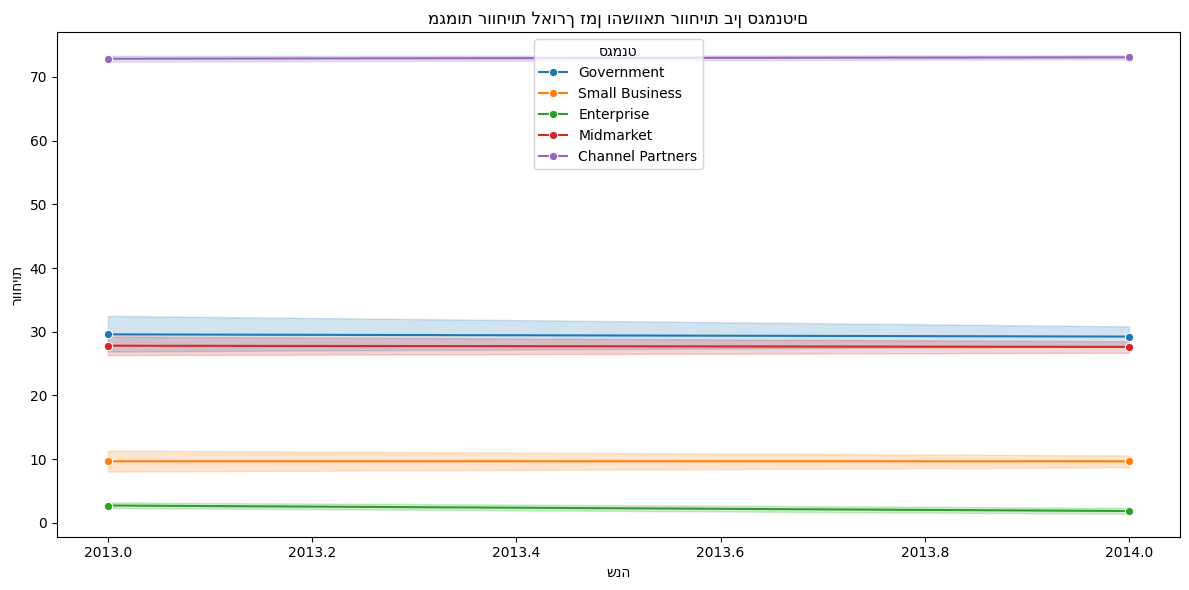

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Product', y='Discount Impact', data=df, palette="Blues_d")
plt.title('השוואת שיעור ההנחות בין מוצרים')
plt.xlabel('מוצר')
plt.ylabel('שיעור ההנחות')
plt.xticks(rotation=90)  # לסובב את שמות המוצרים אם יש הרבה מוצרים
plt.tight_layout()
plt.show()

# גרף להצגת מגמות הרווחיות לאורך זמן תוך השוואת רווחיות בין סגמנטים
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Profit Margin', hue='Segment', data=df, marker='o')
plt.title('מגמות רווחיות לאורך זמן והשוואת רווחיות בין סגמנטים')
plt.xlabel('שנה')
plt.ylabel('רווחיות')
plt.legend(title='סגמנט')
plt.tight_layout()
plt.show()

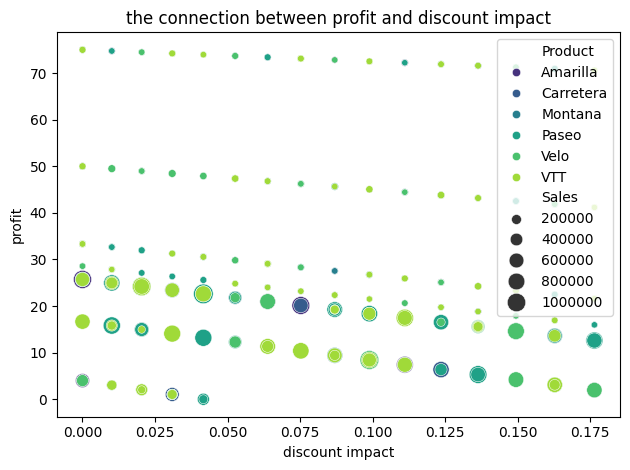

In [18]:
# שימוש ב-Seaborn כדי ליצור גרף פיזור
sns.scatterplot(
    x='Discount Impact', 
    y='Profit Margin', 
    hue='Product',  # כאן אנחנו צבעים את הנקודות לפי מוצר, אפשר לשנות גם ל-'Segment' אם רוצים
    size='Sales',  # שינוי גודל הנקודות לפי מכירות
    sizes=(20, 200),  # טווח גודל הנקודות
    data=df, 
    palette="viridis",  # צבעים לייצוג משתנה ה-Hue
    legend=True
)

plt.title('the connection between profit and discount impact')
plt.xlabel('discount impact')
plt.ylabel('profit')
plt.tight_layout()
plt.show()

 מגמות רווחיות ומכירות לפי שנה:

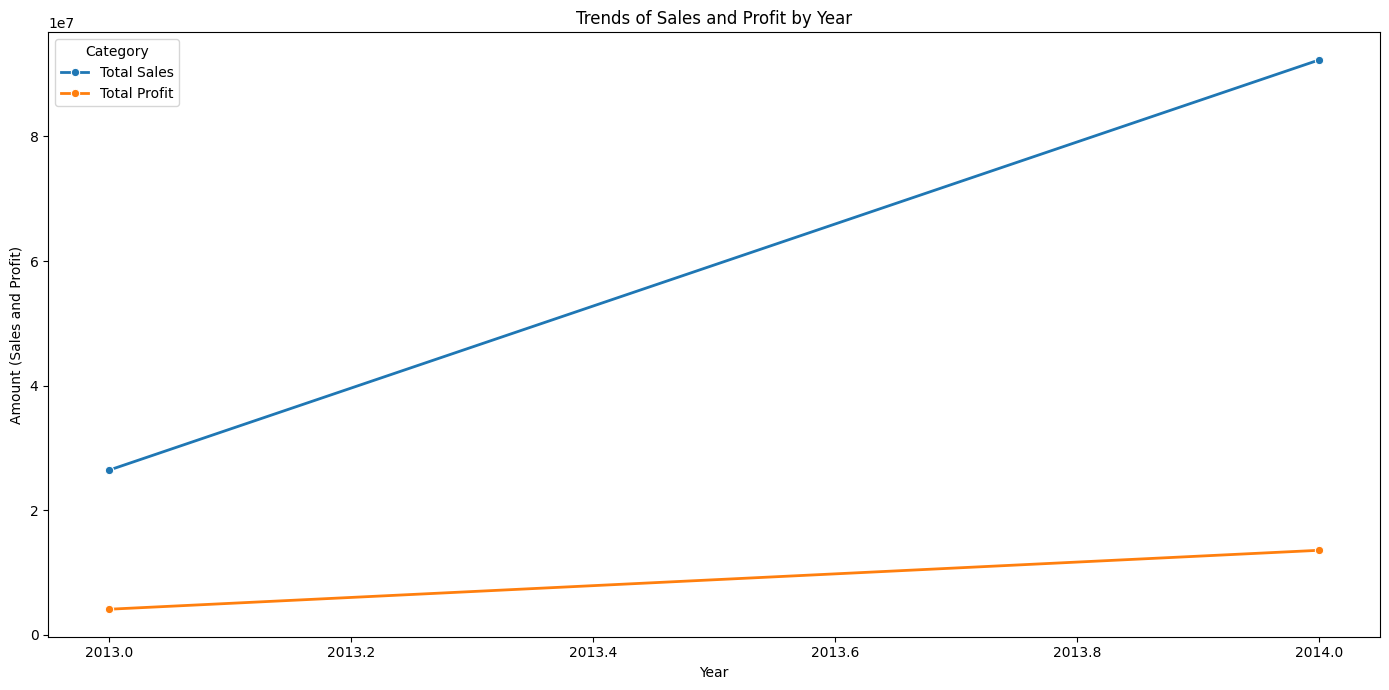

In [26]:
# ניתוח מגמות מכירות ורווחיות לפי שנה
annual_trends = df.groupby('Year').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()

# גרף משולב עם מכירות ורווחיות לאורך השנים
plt.figure(figsize=(14, 7))

# גרף קווים למכירות (Total Sales)
sns.lineplot(data=annual_trends, x='Year', y='Total_Sales', label='Total Sales', marker='o', linewidth=2)

# גרף קווים לרווחיות (Total Profit)
sns.lineplot(data=annual_trends, x='Year', y='Total_Profit', label='Total Profit', marker='o', linewidth=2)

# הוספת כותרת ותגיות
plt.title('Trends of Sales and Profit by Year')
plt.xlabel('Year')
plt.ylabel('Amount (Sales and Profit)')
plt.legend(title='Category', loc='upper left')

# הצגת הגרף
plt.tight_layout()
plt.show()


2. מגמות מכירות ורווחיות לפי חודש:

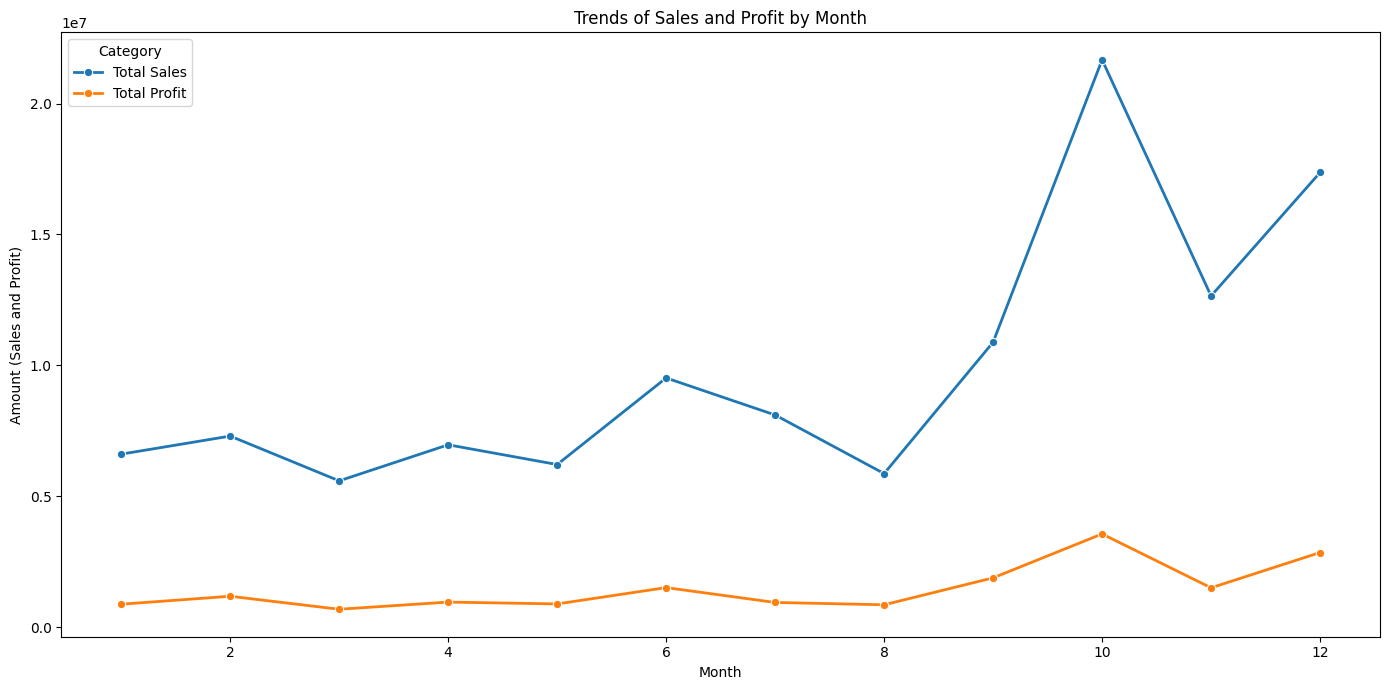

In [27]:
# ניתוח מגמות מכירות ורווחיות לפי חודש
monthly_trends = df.groupby('Month Number').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()

# גרף משולב עם מכירות ורווחיות לאורך חודשים
plt.figure(figsize=(14, 7))

# גרף קווים למכירות (Total Sales)
sns.lineplot(data=monthly_trends, x='Month Number', y='Total_Sales', label='Total Sales', marker='o', linewidth=2)

# גרף קווים לרווחיות (Total Profit)
sns.lineplot(data=monthly_trends, x='Month Number', y='Total_Profit', label='Total Profit', marker='o', linewidth=2)

# הוספת כותרת ותגיות
plt.title('Trends of Sales and Profit by Month')
plt.xlabel('Month')
plt.ylabel('Amount (Sales and Profit)')
plt.legend(title='Category', loc='upper left')

# הצגת הגרף
plt.tight_layout()
plt.show()


3. השוואת רווחיות ומכירות בין סגמנטים (Segment):

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_92479/3694917760.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Year', y='Profit', hue='Segment', alpha=0.3, ci=None)


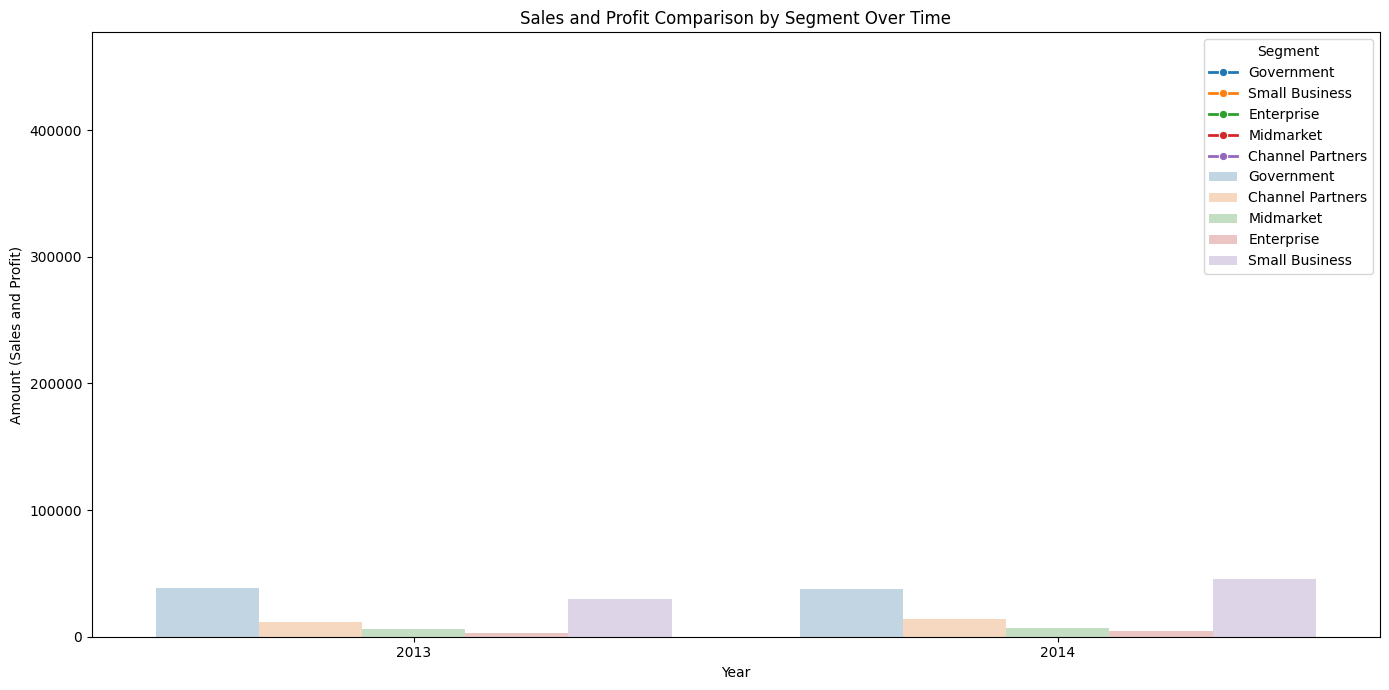

In [28]:
# גרף השוואת רווחיות ומכירות בין סגמנטים
plt.figure(figsize=(14, 7))

# גרף קווים למכירות לפי סגמנט
sns.lineplot(data=df, x='Year', y='Sales', hue='Segment', marker='o', linewidth=2)

# גרף בר לרווחיות לפי סגמנט
sns.barplot(data=df, x='Year', y='Profit', hue='Segment', alpha=0.3, ci=None)

# הוספת כותרת ותגיות
plt.title('Sales and Profit Comparison by Segment Over Time')
plt.xlabel('Year')
plt.ylabel('Amount (Sales and Profit)')
plt.legend(title='Segment')

# הצגת הגרף
plt.tight_layout()
plt.show()


4. מגמות מכירות ורווחיות לפי מדינה (Country):

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_92479/2927490115.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=country_trends, x='Month', y='Total_Profit', hue='Country', alpha=0.3, ci=None)


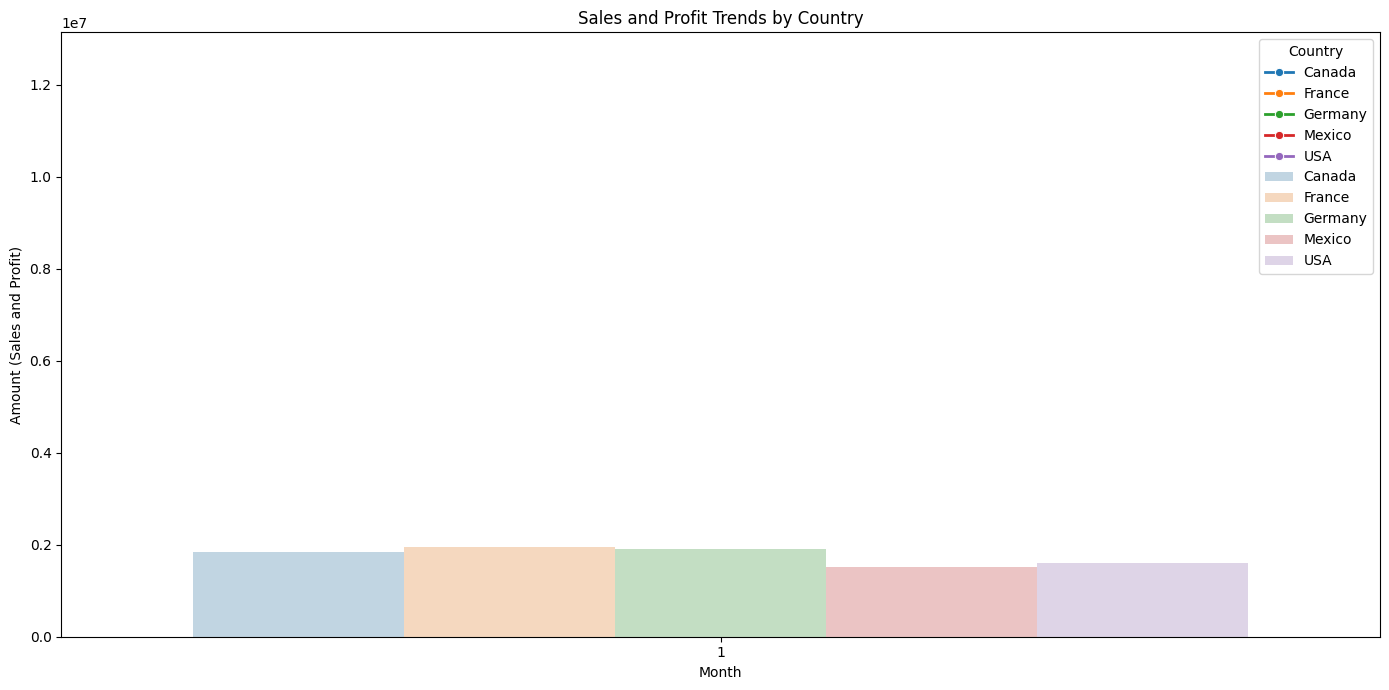

In [29]:
# ניתוח מגמות מכירות ורווחיות לפי מדינה
country_trends = df.groupby(['Year', 'Month', 'Country']).agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum')
).reset_index()

# גרף השוואת מכירות ורווחיות לפי מדינה לאורך הזמן
plt.figure(figsize=(14, 7))

# גרף קווים למכירות לפי מדינה
sns.lineplot(data=country_trends, x='Month', y='Total_Sales', hue='Country', marker='o', linewidth=2)

# גרף בר לרווחיות לפי מדינה
sns.barplot(data=country_trends, x='Month', y='Total_Profit', hue='Country', alpha=0.3, ci=None)

# הוספת כותרת ותגיות
plt.title('Sales and Profit Trends by Country')
plt.xlabel('Month')
plt.ylabel('Amount (Sales and Profit)')
plt.legend(title='Country')

# הצגת הגרף
plt.tight_layout()
plt.show()


כדי לענות על השאלות שהצגת, נוכל לבצע כמה ניתוחים באמצעות גרפים ומדדים מתוך הנתונים.

כדי לזהות אילו מוצרים מציגים רווחיות גבוהה עם שיעור הנחות נמוך, עלינו לבדוק את היחס בין רווחיות לבין שיעור הנחות. אנחנו יכולים ליצור גרף שמציג את רווחיות המוצרים מול שיעור ההנחות שלהם.



שלב ראשון: יצירת גרף המראה את רווחיות המוצרים מול שיעור הנחות

Index(['Product', 'Discount Band', 'Units Sold', 'Sale Price', 'Gross Sales',
       'Discounts', 'Sales', 'COGS', 'Profit', 'Date', 'Month Number',
       'ProductID', 'Category', 'Manufacturing Price', 'Segment', 'Country',
       'Year', 'Month Name', 'Discount Impact', 'Profit Margin', 'Month'],
      dtype='object')


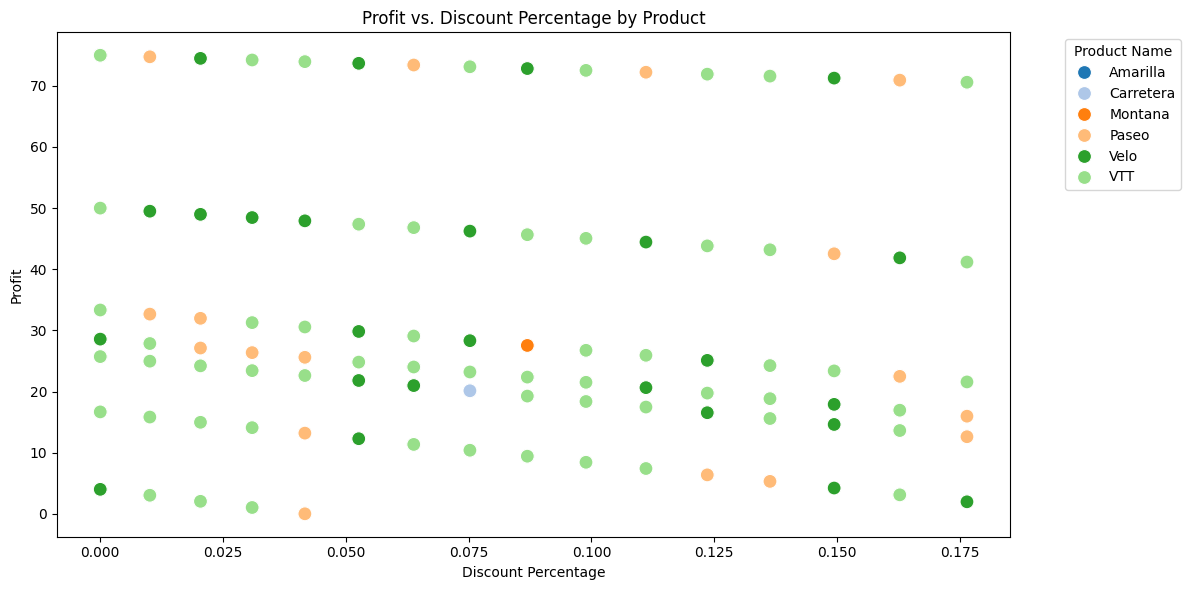

In [34]:
print(df.columns)
# גרף פיזור של רווחיות מול שיעור הנחות למוצרים
plt.figure(figsize=(12, 6))

# גרף פיזור
sns.scatterplot(data=df, x='Discount Impact', y='Profit Margin', hue='Product', palette='tab20', s=100)
# הוספת כותרת ותגיות
plt.title('Profit vs. Discount Percentage by Product')
plt.xlabel('Discount Percentage')
plt.ylabel('Profit')
plt.legend(title='Product Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# הצגת הגרף
plt.tight_layout()
plt.show()


כדי לבדוק אם יש קשר מובהק בין שיעור ההנחות (Discount Impact) לרווחיות (Profit Margin), נוכל לחשב את הקורלציה בין שני המשתנים הללו וליצור גרף פיזור (scatter plot) כדי לראות את הקשר.

שלב ראשון: חישוב הקורלציה

In [35]:
correlation = df['Discount Impact'].corr(df['Profit Margin'])
print(f"קורלציה בין שיעור ההנחות לרווחיות: {correlation}")


קורלציה בין שיעור ההנחות לרווחיות: -0.049701643132810114


אם הקורלציה קרובה ל-1 או -1, זה מעיד על קשר חזק בין שני המשתנים. אם היא קרובה ל-0, זה אומר שאין קשר מובהק.

שלב שני: יצירת גרף פיזור (scatter plot)

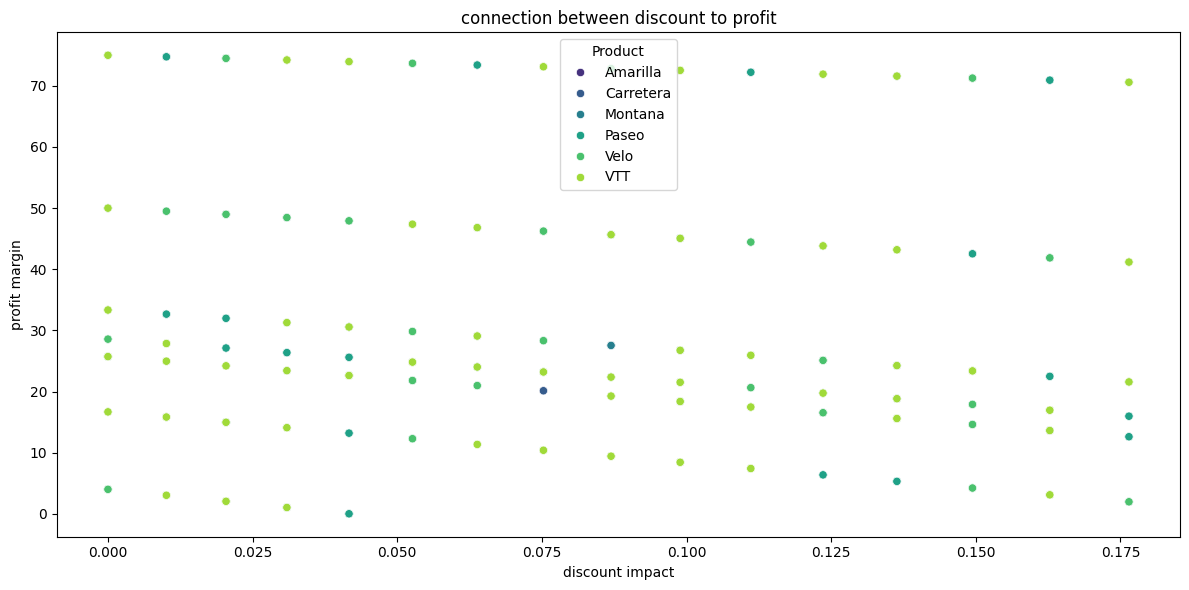

In [37]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Discount Impact', y='Profit Margin', hue='Product', palette='viridis')
plt.title('connection between discount to profit')
plt.xlabel('discount impact')
plt.ylabel('profit margin')
plt.tight_layout()
plt.show()


כדי למצוא את המוצרים/הסגמנטים/המדינות עם ביצועים חלשים, נוכל להגדיר את הקריטריונים על פי Profit Margin ו-Discount Impact, כפי שעשינו קודם. נוכל גם למיין את התוצאות לפי המוצרים/הסגמנטים/המדינות עם הרווחיות הנמוכה ושיעור ההנחות הגבוה.

שלב ראשון: זיהוי מוצרים בעייתיים



In [49]:
profit_margin_threshold = df["Profit Margin"].mean() # לדוגמה, רווחיות נמוכה
discount_impact_threshold = df["Discount Impact"].mean() # לדוגמה, שיעור הנחות גבוה

underperforming_products = df[
    (df["Profit Margin"] < profit_margin_threshold) &  # רווחיות נמוכה
    (df["Discount Impact"] > discount_impact_threshold)  # שיעור הנחות גבוה
]

underperforming_products_summary = underperforming_products.groupby(["Product"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

underperforming_products_summary = underperforming_products_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

print(underperforming_products_summary)


     Product   Total_Sales  Total_Profit  Avg_Discount_Impact  \
4        VTT  7.623383e+06    884477.630             0.124770   
2    Montana  6.059466e+06    732865.530             0.129555   
5       Velo  7.771166e+06    752766.215             0.124239   
1  Carretera  3.877559e+06    430979.050             0.134549   
3      Paseo  1.311462e+07   1628478.665             0.131312   
0   Amarilla  5.384244e+06    639921.920             0.126127   

   Avg_Profit_Margin  
4          16.155908  
2          16.285592  
5          16.463202  
1          16.502096  
3          16.888145  
0          17.235398  


שלב שני: זיהוי סגמנטים עם ביצועים חלשים

In [50]:
underperforming_segments = df[
    (df["Profit Margin"] < profit_margin_threshold) & 
    (df["Discount Impact"] > discount_impact_threshold)
]

underperforming_segments_summary = underperforming_segments.groupby(["Segment"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

underperforming_segments_summary = underperforming_segments_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

print(underperforming_segments_summary)


          Segment   Total_Sales  Total_Profit  Avg_Discount_Impact  \
2  Small Business  2.159058e+07   1373080.000             0.125440   
0      Government  2.107473e+07   3412551.085             0.127731   
1       Midmarket  1.165128e+06    283857.925             0.132625   

   Avg_Profit_Margin  
2           6.213345  
0          17.835817  
1          24.491665  


שלב שלישי: זיהוי מדינות עם ביצועים חלשים

In [51]:
underperforming_countries = df[
    (df["Profit Margin"] < profit_margin_threshold) & 
    (df["Discount Impact"] > discount_impact_threshold)
]

underperforming_countries_summary = underperforming_countries.groupby(["Country"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

underperforming_countries_summary = underperforming_countries_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

print(underperforming_countries_summary)


   Country   Total_Sales  Total_Profit  Avg_Discount_Impact  Avg_Profit_Margin
4      USA  1.117129e+07   1172089.150             0.131092          15.675309
3   Mexico  9.393238e+06   1116998.350             0.128032          15.908725
0   Canada  1.114698e+07   1326428.155             0.134102          15.973623
1   France  6.327735e+06    756297.975             0.125671          17.249175
2  Germany  5.791185e+06    697675.380             0.121361          18.607611


יצירה של 3 מטריקות חדשות וההסבר עליהן  2.3 

In [400]:
# Metric 1: Revenue Contribution
df['Revenue Contribution (%)'] = (df['Gross Sales'] / df['Gross Sales'].sum()) * 100
# Metric 2: Discount Effectiveness
# Avoid dividing by zero for entries with no discounts
df['Discount Effectiveness'] = df.apply(
    lambda row: row['Profit'] / row['Discounts'] if row['Discounts'] != 0 else None, axis=1
)
df['Cost-to-Sales Ratio (%)'] = (df['COGS'] / df['Sales']) * 100
output_filename = "create_three_metrics.csv"
df.to_csv(output_filename, index=False)

יצירת טבלאות מסכמות בעזרת פיווטים 

טבלת מוצר (Product):


In [401]:

# Pivot Table for Product
product_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Product",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum"
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
product_table["Total_Transactions"] = df.groupby("Product")["Units Sold"].count()
output_filename = "product_table_using_pivot.csv"
product_table.to_csv(output_filename, index=False)

טבלת סגמנט (Segment):

In [402]:
# Pivot Table for Segment
segment_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Segment",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum"
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
segment_table["Total_Transactions"] = df.groupby("Segment")["Units Sold"].count()
output_filename = "segment_table_using_pivot.csv"
segment_table.to_csv(output_filename, index=False)

טבלת אזור גיאוגרפי (Country):


In [403]:
# Pivot Table for Country
country_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Country",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum",
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
country_table["Total_Transactions"] = df.groupby("Country")["Units Sold"].count()
country_table = country_table.reset_index()

output_filename = "country_table_using_pivot.csv"
country_table.to_csv(output_filename, index=False)

זיהוי מגמות לאורך זמן 


ניתוח מגמות לפי חודשים (Monthly Trends):

In [404]:
# Monthly Trends Analysis
monthly_trends = df.groupby('Month Number').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()
output_filename = "monthly_trends.csv"
monthly_trends.to_csv(output_filename, index=False)

ניתוח מגמות לפי שנים (Yearly Trends):


In [405]:
# Annual Trends Analysis
annual_trends = df.groupby('Year').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()
output_filename = "annual_trends.csv"
annual_trends.to_csv(output_filename, index=False)

ניתוח של מגמות רבעוניות ,הסבר נמצא 1.6 והקוד למטה מייצר את הטבלה 

In [406]:

# Create a Quarter column
df['Quarter'] = pd.to_datetime(df['Date']).dt.quarter

# Group by Quarter and Product to calculate quarterly trends
quarterly_trends = df.groupby(['Quarter', 'Product']).agg(
    Total_Sales=('Sales', 'sum'),
    Avg_Profit_Margin=('Profit Margin', 'mean'),
    Total_Discounts=('Discounts', 'sum'),
    Total_Profit=('Profit', 'sum')
).reset_index()

# Rename columns for clarity
quarterly_trends = quarterly_trends.rename(columns={
    'Total_Sales': 'Total_Quarterly_Sales',
    'Avg_Profit_Margin': 'Avg_Quarterly_Profit_Margin',
    'Total_Discounts': 'Total_Quarterly_Discounts',
    'Total_Profit': 'Total_Quarterly_Profit'
})

output_filename = "quarterly_trends.csv"
quarterly_trends.to_csv(output_filename, index=False)

יצירת פילטרים מותאמים לניתוח ממוקד ויזהוי בעיות עסקיות


זיהוי מוצרים בעייתיים


In [407]:
# Calculate overall averages for reference
avg_discount_impact = df["Discount Impact"].mean()
avg_profit_margin = df["Profit Margin"].mean()

# Filter problematic products
problematic_products = df[
    (df["Discount Impact"] > avg_discount_impact) &  # Higher than average discount impact
    (df["Profit Margin"] < avg_profit_margin)        # Lower than average profit margin
]

# Aggregate results at the product level
problematic_products_summary = problematic_products.groupby("Product").agg(
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean"),
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum")
).reset_index()

# Sort by highest discount impact
problematic_products_summary = problematic_products_summary.sort_values(
    by="Avg_Discount_Impact", ascending=False
)

output_filename = "problematic_products_summary.csv"
problematic_products_summary.to_csv(output_filename, index=False)


בניית טבלה שתעזור לי למצוא מוצרים המציגים ביצועים חלשים 

In [408]:
# Define thresholds for filtering
profit_margin_threshold = 7  # Bottom quartile (low profitability)
discount_impact_threshold = 8.5  # Top quartile (high discount impact)

# Filter for underperforming products
underperforming_products = df[
    (df["Profit Margin"] < profit_margin_threshold) &  # Low profitability
    (df["Discount Impact"] > discount_impact_threshold)  # High discount impact
]

# Aggregate data at the product level
underperforming_products_summary = underperforming_products.groupby(["Product", "Segment"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

# Sort by Profit Margin (ascending order)
underperforming_products_summary = underperforming_products_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

# Rename columns for clarity
underperforming_products_summary.rename(columns={
    "Total_Sales": "Sales",
    "Total_Profit": "Profit",
    "Avg_Discount_Impact": "Discount Impact",
    "Avg_Profit_Margin": "Profit Margin"
}, inplace=True)

# Display the final summary table
print(underperforming_products_summary)


Empty DataFrame
Columns: [Product, Segment, Sales, Profit, Discount Impact, Profit Margin]
Index: []
